<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/GP_sGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For github continuous integration
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 10
    NUM_SAMPLES = 10
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000

# Structured Gaussian Process

This notebook compares vanilla and structured Gaussian processes for learning a piecewise-linear dynamics. This is adapted from the structured GP example in https://github.com/ziatdinovmax/gpax/blob/main/examples/GP_sGP.ipynb by Maxim Ziatdinov.

## Install & Import

In [2]:
!pip install -q gpax

In [3]:
try:
    # For use on Google Colab
    import gpax
    from .autonotebook import tqdm as notebook_tqdm

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

Assuming notebook is being run locally, attempting to import local gpax module


In [4]:
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

In [5]:
import matplotlib as mpl

In [6]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## Standard and structured GP

We consider a piecewise-linear dynamics system as follows (described in Example 4.3)

In [16]:
def piecewise1(x: np.ndarray, params) -> np.ndarray:
    return np.piecewise(
        x,
        [x < params["th"], x >= params["th"]],
        [lambda x: x*params["a"], lambda x: x*params["b"]])


NUM_INIT_POINTS = 15 # number of observation points
NOISE_LEVEL = 0.1
PARAMS = {"th": 1.0, "a": 1, "b": -1}

np.random.seed(1)
X = np.random.uniform(0, 2, NUM_INIT_POINTS)
y = piecewise1(X, PARAMS) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

X_test = np.linspace(0, 2, 100)


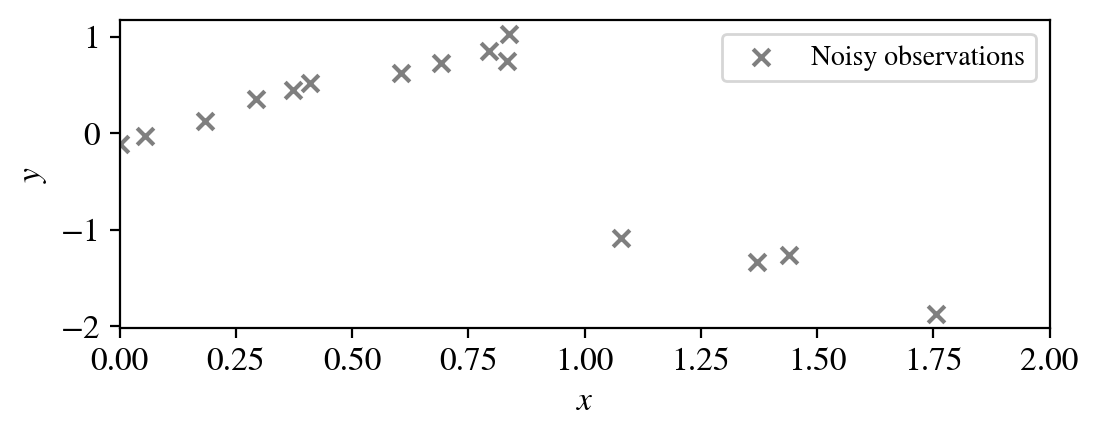

In [17]:
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.scatter(X, y, alpha=0.5, c='k', marker='x', label="Noisy observations")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 2)
plt.savefig('../data.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

Train a vanilla (unstructured) GP model to fit this dataset.

In [18]:
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_key_predict = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern')

# Run HMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_key_predict, X_test, n=100)

sample: 100%|██████████| 4000/4000 [00:15<00:00, 264.18it/s, 3 steps of size 4.65e-01. acc. prob=0.94] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.54      0.25      0.48      0.19      0.89   1175.29      1.00
    k_scale      1.59      1.30      1.25      0.26      2.99    951.04      1.00
      noise      0.14      0.11      0.11      0.01      0.28   1180.63      1.00



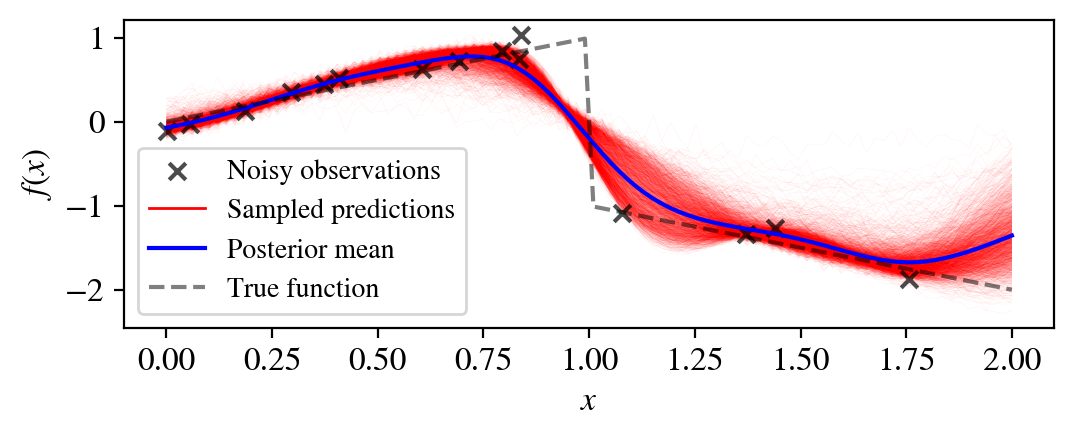

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='lower left')
l.set_alpha(0)
plt.savefig('../unstructuredGP.png', bbox_inches='tight', pad_inches=0.1)

The standard GP does not accurately learn the dynamics. Now, we will encode the piecewise-linear structure of the dynamics in the GP model via JAX.

In [20]:
from typing import Dict

import numpyro
import jax.numpy as jnp

We preserve the piecewise-linearity of the system here, but without knowing the true values of the parameter a, b, and th.

In [21]:
def piecewise1(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["th"], x >= params["th"]],
        [lambda x: x*params["a"], lambda x: x*params["b"]])

We sample a, b and th to generate incorrect prior values.

In [ ]:
def piecewise1_priors():
    # Sample model parameters
    th = numpyro.sample("th", numpyro.distributions.Uniform(0.5, 2.5))
    a = numpyro.sample("a", numpyro.distributions.LogNormal(0, 1))
    b = numpyro.sample("b", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"th": th, "a": a, "b": b}

A structured GP model is trained by passing a piecewise linear function as a mean function with the sampled prior values of the parameters a, b, and th.

In [23]:

# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)

# Run MCMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_key_predict, X_test, n=100)


sample: 100%|██████████| 4000/4000 [15:44<00:00,  4.23it/s, 1023 steps of size 1.70e-03. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      2.28      0.36      2.28      1.73      2.86    192.77      1.00
          b      0.32      0.21      0.26      0.03      0.60    261.40      1.00
k_length[0]      1.92      0.89      1.78      0.75      3.37    221.63      1.00
    k_scale      2.57      2.14      1.95      0.37      5.04    321.50      1.00
      noise      0.04      0.03      0.03      0.01      0.07    395.42      1.00
          t      0.96      0.07      0.96      0.85      1.06    317.40      1.01



KeyError: 'th'

In [ ]:

# Plot results
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.set_xlabel("$x$")
ax.set_ylabel("$f(x)$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='upper right')
l.set_alpha(0)
plt.savefig('../structuredGP.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

NameError: name 'plt' is not defined